# Road Lane Detection Algorithm

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def canny(img, kernel, thresh):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.GaussianBlur(img, (kernel, kernel), 0)
    img = cv2.Canny(img, thresh[0], thresh[1])
    img = img / 255
    
    return img

def hls_select(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

def binary_image(img, kernel = 3, thresh_c = (0, 255), thresh_h = (0, 255)):
    canny_binary = canny(img, kernel, thresh_c)
    hls_binary = hls_select(img, thresh_h)
    binary = np.zeros_like(canny_binary)
    binary[(canny_binary == 1) | (hls_binary == 1)] = 1
    
    return binary

def perspective_transform(binary, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(binary, M, binary.shape[::-1], flags=cv2.INTER_LINEAR)
    
    return warped

def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 10
    margin = 25
    minpix = 20
    window_height = np.int(binary_warped.shape[0]//nwindows)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

def search_around_poly(binary_warped, left_fit, right_fit):
    margin = 20

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

def view_out(image, warped, left_fitx, right_fitx, ploty, Minv):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int([pts]), (0, 255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    plt.imshow(result)

In [3]:
top_y = 265
bottom_y = 480
top_centre = 366
bottom_centre = 394
top_margin = 36
bottom_margin = 350

src = np.float32([[(top_centre + top_margin), top_y],
                  [(bottom_centre + bottom_margin), bottom_y],
                  [(bottom_centre - bottom_margin), bottom_y],
                  [(top_centre - top_margin), top_y]])
dst = np.float32([[720, 0], [720, 480], [0, 480], [0, 0]])
Minv = cv2.getPerspectiveTransform(dst, src)

### Initial Frame

Implementing Sliding Windows and Fit a Polynomial


In [4]:
image1 = cv2.imread('image1.png')
binary1 = binary_image(image1, 1, (90, 200), (84, 255))
warped1 = perspective_transform(binary1, src, dst)

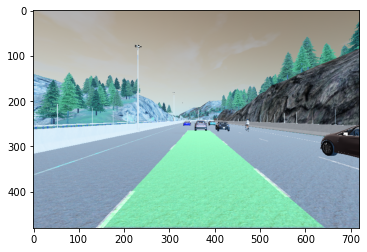

In [5]:
leftx, lefty, rightx, righty = find_lane_pixels(warped1)
left_fit, right_fit = fit_poly(warped1.shape, leftx, lefty, rightx, righty)

ploty = np.linspace(0, warped1.shape[0]-1, warped1.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

view_out(image1, warped1, left_fitx, right_fitx, ploty, Minv)

### Later frames

Skip the sliding windows step once you've found the lines

In [6]:
image2 = cv2.imread('image2.png')
binary2 = binary_image(image2, 1, (90, 200), (84, 255))
warped2 = perspective_transform(binary2, src, dst)

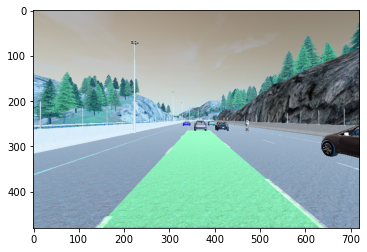

In [7]:
leftx, lefty, rightx, righty = search_around_poly(warped2, left_fit, right_fit)
left_fit, right_fit = fit_poly(warped2.shape, leftx, lefty, rightx, righty)

ploty = np.linspace(0, warped2.shape[0]-1, warped2.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

view_out(image2, warped2, left_fitx, right_fitx, ploty, Minv)